In [76]:
import sys
sys.path.append('/usr/wrk/people9/sima9999/git/pyOMA')
import numpy as np
from uncertainty.data_manager import DataManager, HiddenPrints
import logging
logger = logging.getLogger('uncertainty.data_manager')
logger.setLevel(level=logging.DEBUG)
from core.StabilDiagram import StabilCalc
title='uq_acqui2'
data_manager = DataManager.from_existing(dbfile_in=f'{title}.nc', 
                                         result_dir=f'/usr/scratch4/sima9999/work/modal_uq/{title}/')

DEBUG:uncertainty.data_manager:opening existing file uq_acqui2.nc


In [87]:

i=0
with data_manager.get_database(database='out', rw=False) as ds:
    pass
#     for jid in ds.ids:
#         ds.model_order.loc[jid]
#         if np.isnan(ds.modal_frequencies.loc[jid]).all():
#             i+=1
#         else:
#             ds._exceptions.loc[jid] = ''
# display(i)
#     ds.attrs['dbfile_in'] = 'uq_acqui2.nc'
#     ds.attrs['dbfile_out'] = 'uq_acqui2_out.nc'
#     ds.attrs['result_dir'] = '/usr/scratch4/sima9999/work/modal_uq/uq_acqui2/'
#     ds.attrs['title'] = 'uq_acqui2'
    
display(ds.loc[{'ids':ds._exceptions==''}])

DEBUG:uncertainty.data_manager:opening existing file uq_acqui2_out.nc


<xarray.Dataset>
Dimensions:              (ids: 465, modes: 100, channels: 10)
Coordinates:
  * ids                  (ids) object '28986fdf231e' ... '5dabb3f61d99'
Dimensions without coordinates: modes, channels
Data variables: (12/20)
    _exceptions          (ids) object '' '' '' '' '' '' '' ... '' '' '' '' '' ''
    _runtimes            (ids) float64 7.085e+03 7.699e+03 ... 4.511e+03
    cutoff               (ids) float64 82.79 82.78 69.03 ... 196.5 156.4 145.0
    damping_a            (ids, modes) float64 0.06708 0.03516 ... nan nan
    dec_rate             (ids) int64 44 37 28 26 26 30 37 ... 32 35 26 46 36 28
    frequencies_a        (ids, modes) float64 6.451 19.38 32.29 ... nan nan nan
    ...                   ...
    num_cycles           (ids) int64 1335 1442 606 848 766 ... 729 1460 925 559
    numtaps              (ids) int64 1540 407 476 468 728 ... 546 1564 1440 336
    sim_steps            (ids) int64 1732438 1871394 665800 ... 2297730 1278794
    snr_alias            (ids, channels) float64 2.184e+05 1.141e+06 ... nan nan
    snr_db_out           (ids, channels) float64 -18.46 -18.48 ... nan nan
    snr_quant            (ids, channels) float64 17.81 17.75 17.86 ... nan nan
Attributes:
    date:         datetime.date(2021, 9, 17)
    dbfile_in:    uq_acqui2.nc
    dbfile_out:   uq_acqui2_out.nc
    entropy:      907680313
    result_dir:   /usr/scratch4/sima9999/work/modal_uq/uq_acqui2/
    title:        uq_acqui2
    working_dir:  /run/user/30980/work

In [3]:
def func(ds):
    '''
    plot all numerical natural frequencies to get a feeling for their distribution
    
    modal parameters:
    for each jid:
        assign each identified mode to the respective numerical
        mark unidentified and wrongly identified
        compute normalized frequency and damping differences (numerical, identified), MAC values
    
    per-channel output variables:
        reduce to mean and coefficient of variation
    '''
#     for name in ds.data_vars:
#         if name.startswith('_'): continue
#         print(name, ds[name].dims)
    
    num_samples = ds.ids.size
    num_modes = ds.modes.size
    num_channels = ds.channels.size
    
    ds['freq_diff'] = (['ids','modes'], np.full(shape=(num_samples, num_modes), fill_value=np.nan))
    ds['damp_diff'] = (['ids','modes'], np.full(shape=(num_samples, num_modes), fill_value=np.nan))
    ds['modal_assurance'] = (['ids','modes'], np.full(shape=(num_samples, num_modes), fill_value=np.nan))
    ds['unp_num'] = (['ids'], np.zeros((num_samples,)))
    ds['unp_id'] = (['ids'], np.zeros((num_samples,)))    
#     skip=True    
    print_ids = ds.ids[np.linspace(0, num_samples-1, 100, dtype=int)]
    #print(print_ids)
    for jid in ds.ids:
        if jid.item() in print_ids: print('.', end='', flush=True)
#         print(jid.item()
#         if jid!='123a8b385cb9':
#             if skip:continue
#         skip=False
        freq_a = ds['frequencies_a'].loc[jid].dropna('modes', 'all')
        freq_id = ds['modal_frequencies'].loc[jid].dropna('modes', 'all')
        damp_a = ds['damping_a'].loc[jid].dropna('modes', 'all')
        damp_id = ds['modal_damping'].loc[jid].dropna('modes', 'all')
        shapes_a = ds['mode_shapes_a'].loc[jid].dropna('modes', 'all').dropna('channels', 'all')
        shapes_id = ds['mode_shapes'].loc[jid].dropna('modes', 'all').dropna('channels', 'all')
        
        ind_num, ind_id, unp_num, unp_id= pair_modes(freq_a, freq_id,
                                                     shapes_a, shapes_id,)
        n_pairs = len(ind_num)
        ds['unp_num'].loc[jid] = unp_num
        ds['unp_id'].loc[jid] = unp_id
        
        freq_diff = (freq_a[ind_num] - freq_id[ind_id])/(0.5 * (freq_a[ind_num] + freq_id[ind_id]))
        ds['freq_diff'].loc[jid][ind_num] = freq_diff
        damp_diff = (damp_a[ind_num] - damp_id[ind_id])
        ds['damp_diff'].loc[jid][ind_num] = damp_diff
        mac_values = np.diag(StabilCalc.calculateMAC(shapes_a[:,ind_num], shapes_id[:,ind_id]))
        ds['modal_assurance'].loc[jid][ind_num] = mac_values       
    
    print('.', end='\n', flush=True)
    
    #ds['this_delta_f'] = ds['freq_diff'].mean(dim='modes')
    #ds['this_delta_d'] = ds['damp_diff'].mean(dim='modes')
    #ds['this_mac'] = ds['modal_assurance'].mean(dim='modes')
    
    ds['duration'] = ds.num_cycles/ds.frequencies_a.min(dim='modes')
    ds['window'] = ('ids', ds.window.data=='hann', {'dist_type': 'integers', 'dist_params': np.array([0,2])})
    
    #dt_fact=0.01
    ds['deltat'] = 1 / ds.fs
    ds['timesteps'] = ds.duration / ds.deltat # N
    ds['bits'] = ds['bits2']
    ds['bits_eff']=(np.log(ds.margin*(2**ds.bits))/np.log(2)).mean('channels')
    
    ds.unp_num.attrs = {'dist_type': 'integers', 'dist_params': np.array([1,9])}
    ds.unp_id.attrs = {'dist_type': 'integers', 'dist_params': np.array([0,92])}
    ds.dec_rate.attrs = {'dist_type': 'integers', 'dist_params': np.array([6,83])}
    
    ds['all_n_cycl'] = ds.duration * ds.frequencies_a
    ds = ds.rename_dims({'ids':'ids_'})
    ds = ds.stack(ids=('ids_','modes'))
    ds = ds.dropna('ids','all',subset=('freq_diff',))
    ds = ds.reset_index('ids')
    ds = ds.reset_coords(['ids_','modes'])
    
    ds['this_snr_alias'] = ds['snr_alias'].mean(dim='channels')
    ds['this_snr_quant'] = ds['snr_quant'].mean(dim='channels')
    ds['this_snr_db_out'] = ds['snr_db_out'].mean(dim='channels')
    
    return ds
        
def pair_modes(freq_num, freq_ident, 
               shapes_num, shapes_ident, 
               freq_thresh=0.2, mac_thresh=0.8):
    '''
    A function to pair two sets of modes (here: numerical and identified) 
    based on frequency differences and mode shape similarity
    the number of modes in both sets may be different and
    relative complements of both array may be non-empty
    
    a threshold where pairing stops is based on 
        normalized frequency differences AND modal assurance criteria
    
    returns:
        * integer array indexers for both arrays 
          sorted to return ascending frequencies (numerical)
          length represents the number of common modes
        * for both sets a count for the number of unpaired modes
    
    '''
#   print(freq_num, freq_ident)
#     for array in [freq_num, freq_ident, shapes_num, shapes_ident]:
#         print(array)
#         assert not np.any(np.isnan(array))
    shape=(len(freq_num), len(freq_ident))
    delta_matrix = np.ma.array(np.zeros(shape), mask=np.zeros(shape))
    for index, frequency in enumerate(freq_num):
        delta_matrix[index, :] = np.abs(
            (freq_ident - frequency) / (0.5*(freq_ident + frequency)) )
    
    mac_matrix = StabilCalc.calculateMAC(shapes_num, shapes_ident) 
#   might have to be transposed
#   indices and sizes of delta_matrix and mac_matrix should be equal
#   print(delta_matrix.shape, mac_matrix.shape)
#   print(delta_matrix, mac_matrix)
    
    indices_num = []
    indices_ident = []
    delta_values = []
    mac_values = []
    
    while ~np.all(delta_matrix.mask):
        # find index of smallest frequency difference
        row, col = np.unravel_index(
            np.argmin(delta_matrix), delta_matrix.shape)
        
        # if another column contains a minimal value in the same row
        # do not mask the column
        for col_ind in range(delta_matrix.shape[1]):
            if col_ind == col:
                continue
            if delta_matrix[:, col_ind].mask.all():
                continue
            if np.argmin(delta_matrix[:, col_ind]) == row:
                del_col = False
                break
        else:
            del_col = True
            col_ind = col
        # if another row contains a minimal value in the same column
        # do not mask the row
        for row_ind in range(delta_matrix.shape[0]):
            if row_ind == row:
                continue
            if delta_matrix[row_ind, :].mask.all():
                continue
            if np.argmin(delta_matrix[row_ind, :]) == col:
                del_row = False
                break
        else:
            del_row = True
            row_ind = row
            
#         print(row,col,delta_matrix[row,col]<freq_thresh, mac_matrix[row,col]>mac_thresh, del_row,del_col)
        
        if delta_matrix[row,col]<freq_thresh and mac_matrix[row,col]>mac_thresh:#del_col and del_row:
            delta_values.append(delta_matrix[row, col])
            mac_values.append(mac_matrix[row, col])
            delta_matrix[row, :] = np.ma.masked
            delta_matrix[:, col] = np.ma.masked            
            indices_num.append(row)
            indices_ident.append(col)
        
        # we still have do something,
        # else we would stay in an infinite loop here
        elif del_row and del_col:
            delta_matrix[row, :] = np.ma.masked
            delta_matrix[:, col] = np.ma.masked   
        
        # in the case, where we might discard a candidate for a good match for another mode
        # we use the modal assurance criterion to decide which mode to discard
        # counter-intuitively that should be the best matching mode of several candidates
        elif not (del_row and del_col): # one of both must be false
            # both members of the selected pair also have another close match
            # which of the three candidates has the best MAC value?
            best = np.argmax([mac_matrix[row_ind, col], mac_matrix[row, col_ind], mac_matrix[row, col]])
            if best==0:
                # another row (row_ind) contains a minimal value in the same column 
                row=row_ind
            elif best==1:
                # another column (col_ind) contains a minimal value in the same row
                col=col_ind
            else: 
                # initial mode is better candidate
                pass
            delta_matrix[row, :] = np.ma.masked
            delta_matrix[:, col] = np.ma.masked        
        else:
            print(delta_matrix)
            print(col_ind, row_ind, col, row)
            print(delta_matrix[row_ind, col_ind], 
                  delta_matrix[:, col_ind],
                  delta_matrix[row_ind, :])
            raise RuntimeError('Caught in a loop')

    
    # now sort according to ascending numerical frequencies
    sort_inds = np.argsort(freq_num.data[indices_num])

    indices_num = np.array(indices_num)[sort_inds]
    indices_ident = np.array(indices_ident)[sort_inds]
    
    unp_num = [i for i in range(len(freq_num)) if i not in indices_num]
    unp_ident = [i for i in range(len(freq_ident)) if i not in indices_ident]
    
#     print((freq_num[indices_num]-freq_ident[indices_ident])/(0.5*(freq_num[indices_num]+freq_ident[indices_ident])))
#     print(np.array(delta_values)[sort_inds])
#     print('\n')
#     print(mac_matrix[indices_num, indices_ident])
#     print(np.array(mac_values)[sort_inds])
#     print('\n')
#     print(freq_num[indices_num], freq_num[unp_num])
#     print(freq_ident[indices_ident], freq_ident[unp_ident])

    return indices_num, indices_ident, len(unp_num), len(unp_ident)

DEBUG:uncertainty.data_manager:opening existing file uq_acqui.nc
DEBUG:uncertainty.data_manager:opening existing file uq_acqui_out.nc
INFO:uncertainty.data_manager:Applying user-supplied function func to dataset and save results (True)...
.....................................................................................................
DEBUG:uncertainty.data_manager:Saving database to /usr/scratch4/sima9999/work/modal_uq/uq_acqui/uq_acqui_processed.nc
INFO:uncertainty.data_manager:We saved the database outside the safe loop, ensure to load the "processed" db for future use
number of samples 6120
INFO:uncertainty.data_manager:Categorizing data arrays ...
INFO:uncertainty.data_manager:Creating the scatterplot matrix... 


/usr/wrk/people9/sima9999/my-python/lib/python3.8/site-packages/xarray/backends/h5netcdf_.py:315: FutureWarning: complex dtypes are supported by h5py, but not part of the NetCDF API. You are writing an HDF5 file that is not a valid NetCDF file! In the future, this will be an error, unless you set invalid_netcdf=True.
  nc4_var = self.ds.create_variable(


DEBUG:uncertainty.data_manager:hist bits
DEBUG:uncertainty.data_manager:hist bits2
DEBUG:uncertainty.data_manager:hist damping
DEBUG:uncertainty.data_manager:hist freq_scale
DEBUG:uncertainty.data_manager:hist lumped
DEBUG:uncertainty.data_manager:hist num_cycles
DEBUG:uncertainty.data_manager:hist num_modes
DEBUG:uncertainty.data_manager:hist num_sensors
DEBUG:uncertainty.data_manager:hist numtaps_fact
DEBUG:uncertainty.data_manager:hist nyq_rat
DEBUG:uncertainty.data_manager:hist order_factor
DEBUG:uncertainty.data_manager:hist snr_db
DEBUG:uncertainty.data_manager:hist tau_max
DEBUG:uncertainty.data_manager:hist window
DEBUG:uncertainty.data_manager:hist cutoff


<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


DEBUG:uncertainty.data_manager:hist damping_a
DEBUG:uncertainty.data_manager:hist dec_rate
DEBUG:uncertainty.data_manager:hist frequencies_a
DEBUG:uncertainty.data_manager:hist fs
DEBUG:uncertainty.data_manager:hist modal_contributions
DEBUG:uncertainty.data_manager:hist modal_damping
DEBUG:uncertainty.data_manager:hist modal_frequencies
DEBUG:uncertainty.data_manager:hist model_order
DEBUG:uncertainty.data_manager:hist numtaps
DEBUG:uncertainty.data_manager:hist sim_steps
DEBUG:uncertainty.data_manager:hist freq_diff
DEBUG:uncertainty.data_manager:hist damp_diff
DEBUG:uncertainty.data_manager:hist modal_assurance
DEBUG:uncertainty.data_manager:hist unp_num
DEBUG:uncertainty.data_manager:hist unp_id
DEBUG:uncertainty.data_manager:hist duration
DEBUG:uncertainty.data_manager:hist deltat
DEBUG:uncertainty.data_manager:hist timesteps
DEBUG:uncertainty.data_manager:hist bits_eff
DEBUG:uncertainty.data_manager:hist all_n_cycl
DEBUG:uncertainty.data_manager:hist ids_
DEBUG:uncertainty.data_m

DEBUG:uncertainty.data_manager:scatter freq_scale,dec_rate
DEBUG:uncertainty.data_manager:scatter freq_scale,frequencies_a
DEBUG:uncertainty.data_manager:scatter freq_scale,fs
DEBUG:uncertainty.data_manager:scatter freq_scale,modal_contributions
DEBUG:uncertainty.data_manager:scatter freq_scale,modal_damping
DEBUG:uncertainty.data_manager:scatter freq_scale,modal_frequencies
DEBUG:uncertainty.data_manager:scatter freq_scale,model_order
DEBUG:uncertainty.data_manager:scatter freq_scale,numtaps
DEBUG:uncertainty.data_manager:scatter freq_scale,sim_steps
DEBUG:uncertainty.data_manager:scatter freq_scale,freq_diff
DEBUG:uncertainty.data_manager:scatter freq_scale,damp_diff
DEBUG:uncertainty.data_manager:scatter freq_scale,modal_assurance
DEBUG:uncertainty.data_manager:scatter freq_scale,unp_num
DEBUG:uncertainty.data_manager:scatter freq_scale,unp_id
DEBUG:uncertainty.data_manager:scatter freq_scale,duration
DEBUG:uncertainty.data_manager:scatter freq_scale,deltat
DEBUG:uncertainty.data_ma

DEBUG:uncertainty.data_manager:scatter num_sensors,modal_frequencies
DEBUG:uncertainty.data_manager:scatter num_sensors,model_order
DEBUG:uncertainty.data_manager:scatter num_sensors,numtaps
DEBUG:uncertainty.data_manager:scatter num_sensors,sim_steps
DEBUG:uncertainty.data_manager:scatter num_sensors,freq_diff
DEBUG:uncertainty.data_manager:scatter num_sensors,damp_diff
DEBUG:uncertainty.data_manager:scatter num_sensors,modal_assurance
DEBUG:uncertainty.data_manager:scatter num_sensors,unp_num
DEBUG:uncertainty.data_manager:scatter num_sensors,unp_id
DEBUG:uncertainty.data_manager:scatter num_sensors,duration
DEBUG:uncertainty.data_manager:scatter num_sensors,deltat
DEBUG:uncertainty.data_manager:scatter num_sensors,timesteps
DEBUG:uncertainty.data_manager:scatter num_sensors,bits_eff
DEBUG:uncertainty.data_manager:scatter num_sensors,all_n_cycl
DEBUG:uncertainty.data_manager:scatter num_sensors,ids_
DEBUG:uncertainty.data_manager:scatter num_sensors,modes
DEBUG:uncertainty.data_manag

DEBUG:uncertainty.data_manager:scatter tau_max,window
DEBUG:uncertainty.data_manager:scatter tau_max,cutoff
DEBUG:uncertainty.data_manager:scatter tau_max,damping_a
DEBUG:uncertainty.data_manager:scatter tau_max,dec_rate
DEBUG:uncertainty.data_manager:scatter tau_max,frequencies_a
DEBUG:uncertainty.data_manager:scatter tau_max,fs
DEBUG:uncertainty.data_manager:scatter tau_max,modal_contributions
DEBUG:uncertainty.data_manager:scatter tau_max,modal_damping
DEBUG:uncertainty.data_manager:scatter tau_max,modal_frequencies
DEBUG:uncertainty.data_manager:scatter tau_max,model_order
DEBUG:uncertainty.data_manager:scatter tau_max,numtaps
DEBUG:uncertainty.data_manager:scatter tau_max,sim_steps
DEBUG:uncertainty.data_manager:scatter tau_max,freq_diff
DEBUG:uncertainty.data_manager:scatter tau_max,damp_diff
DEBUG:uncertainty.data_manager:scatter tau_max,modal_assurance
DEBUG:uncertainty.data_manager:scatter tau_max,unp_num
DEBUG:uncertainty.data_manager:scatter tau_max,unp_id
DEBUG:uncertainty.

DEBUG:uncertainty.data_manager:scatter frequencies_a,bits_eff
DEBUG:uncertainty.data_manager:scatter frequencies_a,all_n_cycl
DEBUG:uncertainty.data_manager:scatter frequencies_a,ids_
DEBUG:uncertainty.data_manager:scatter frequencies_a,modes
DEBUG:uncertainty.data_manager:scatter frequencies_a,this_snr_alias
DEBUG:uncertainty.data_manager:scatter frequencies_a,this_snr_quant
DEBUG:uncertainty.data_manager:scatter frequencies_a,this_snr_db_out
DEBUG:uncertainty.data_manager:scatter fs,modal_contributions
DEBUG:uncertainty.data_manager:scatter fs,modal_damping
DEBUG:uncertainty.data_manager:scatter fs,modal_frequencies
DEBUG:uncertainty.data_manager:scatter fs,model_order
DEBUG:uncertainty.data_manager:scatter fs,numtaps
DEBUG:uncertainty.data_manager:scatter fs,sim_steps
DEBUG:uncertainty.data_manager:scatter fs,freq_diff
DEBUG:uncertainty.data_manager:scatter fs,damp_diff
DEBUG:uncertainty.data_manager:scatter fs,modal_assurance
DEBUG:uncertainty.data_manager:scatter fs,unp_num
DEBUG:

DEBUG:uncertainty.data_manager:scatter freq_diff,damp_diff
DEBUG:uncertainty.data_manager:scatter freq_diff,modal_assurance
DEBUG:uncertainty.data_manager:scatter freq_diff,unp_num
DEBUG:uncertainty.data_manager:scatter freq_diff,unp_id
DEBUG:uncertainty.data_manager:scatter freq_diff,duration
DEBUG:uncertainty.data_manager:scatter freq_diff,deltat
DEBUG:uncertainty.data_manager:scatter freq_diff,timesteps
DEBUG:uncertainty.data_manager:scatter freq_diff,bits_eff
DEBUG:uncertainty.data_manager:scatter freq_diff,all_n_cycl
DEBUG:uncertainty.data_manager:scatter freq_diff,ids_
DEBUG:uncertainty.data_manager:scatter freq_diff,modes
DEBUG:uncertainty.data_manager:scatter freq_diff,this_snr_alias
DEBUG:uncertainty.data_manager:scatter freq_diff,this_snr_quant
DEBUG:uncertainty.data_manager:scatter freq_diff,this_snr_db_out
DEBUG:uncertainty.data_manager:scatter damp_diff,modal_assurance
DEBUG:uncertainty.data_manager:scatter damp_diff,unp_num
DEBUG:uncertainty.data_manager:scatter damp_diff

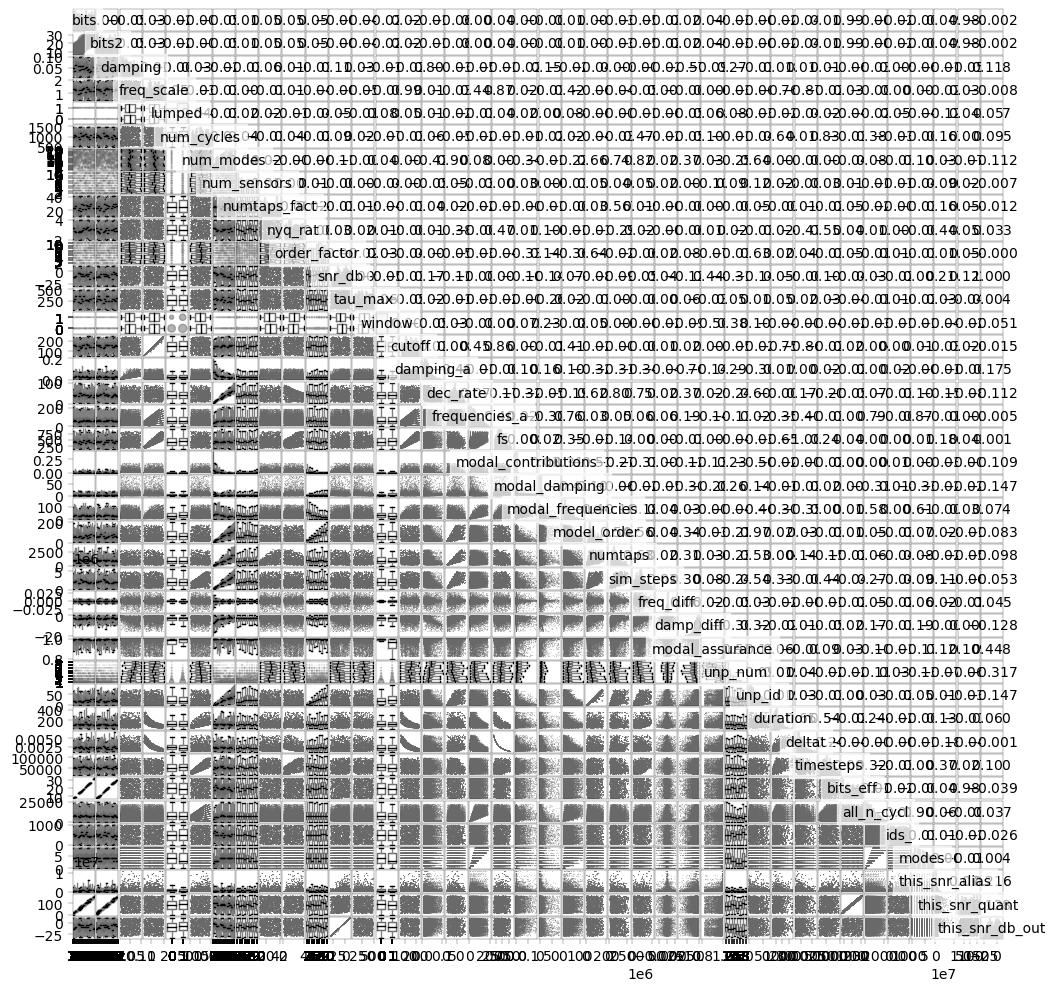

In [4]:
data_manager.post_process_samples(db='merged',func=func, rw=True)

In [ ]:
with data_manager.get_database(database='out', rw=False) as ds:
    ds


# ds['duration'] = ds.num_cycles/ds.frequencies_a.min(dim='modes')

# #dt_fact=0.01
# #ds['deltat'] = dt_fact / ds.frequencies_a.max(dim='modes')
# #ds['timesteps'] = ds.duration / ds.deltat # N

# ds['all_n_cycl'] = ds.duration * ds.frequencies_a
# ds = ds.rename_dims({'ids':'ids_'})
# #display(ds)
# ds = ds.stack(ids=('ids_','modes'))
# #display(ds.ids_)
# ds = ds.dropna('ids','all')
# #display(ds)
# ds = ds.reset_index('ids')
display(ds.frequencies_a.dropna("ids", "all"))

In [ ]:
with data_manager.get_database(database='processed', rw=True) as ds:
    #ds.unp_num.attrs = {'dist_type': 'integers', 'dist_params': np.array([1,9])}
    #ds.unp_id.attrs = {'dist_type': 'integers', 'dist_params': np.array([0,92])}
    #ds.dec_rate.attrs = {'dist_type': 'integers', 'dist_params': np.array([6,83])}
    ds['window'] = ('ids', ds.window.data=='hann', {'dist_type': 'integers', 'dist_params': np.array([0,2])})
    #ds['numtaps_fact'] = ds.numtaps / ds.dec_rate #= ds.reset_coords(['ids_','modes'])
    #ds['nyq_rat'] = ds.fs/ds.cutoff
    #ds.to_netcdf('/usr/scratch4/sima9999/work/modal_uq/uq_acqui/uq_acqui_processed2.nc',engine='h5netcdf')
    pass
display(ds)

In [ ]:
ds['window'] = ('ids', ds.window.data=='hann', {'dist_type': 'integers', 'dist_params': np.array([0,2])})

In [ ]:
ds

In [ ]:
import matplotlib.pyplot as plt
fig,_ = plt.subplots(3,3)

In [ ]:
axes=fig.get_axes()


In [ ]:
for ax in axes:
    sps = ax.get_subplotspec()
    col, row = sps.colspan.start, sps.rowspan.start
    print(col,row)


In [ ]:
ax.set_xticks([0,1])
ax.set_xticklabels(['lumped','distributed'])